## 1. Bibliotecas

In [32]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.subplots as sp

# Models
from statsforecast import StatsForecast
from statsforecast.models import WindowAverage, AutoARIMA, Naive, SeasonalNaive, SeasonalWindowAverage
from pmdarima import auto_arima

# Utils
import warnings
import datetime
from tqdm import tqdm

In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Tratamento dos Dados

Os dados foram coletados do site **Investing**. A série histórica do iBovespa coletada vai de 03/01/2005 até 16/07/2024

### 2.1 Lendo os dados

In [5]:
df_original = pd.read_csv("ibovespa-historical.csv")
df_original.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,07/16/2024,"129,110","129,322","129,521","128,761",6.82B,-0.16%
1,07/15/2024,"129,321","128,898","129,485","128,723",5.83B,0.33%
2,07/12/2024,"128,897","128,293","129,015","128,002",7.21B,0.47%
3,07/11/2024,"128,294","127,221","128,326","127,221",7.97B,0.85%
4,07/10/2024,"127,218","127,109","127,769","126,928",8.15B,0.09%


### 2.2 Pré-processamento dos daods

Copiando o dataframe original para evitar modificá-lo

In [6]:
df = df_original.copy()

Filtrando as colunas de interesse

In [7]:
df = df[["Date", "Price"]]

Modificando o tipo da coluna data para facilitar a manipulação

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

Renomeando as colunas para o padrão de séries temporais

In [9]:
df = df.rename(columns={'Date': 'ds', 'Price': 'y'})

Removendo o separador de milhares

In [11]:
df['y'] = df['y'].str.replace(',', '').astype(int)

Preenchendo os valores nulos (como a bolsa brasileira não opera em algumas datas, essas datas estão sendo preenchidas com os valores do dia anterior de operação)

In [12]:
# Definindo o intervalo de datas
data_inicio = df['ds'].min()
data_fim = df['ds'].max()

# Criando uma lista de datas
lista_datas = [data_inicio + datetime.timedelta(days=d) for d in range((data_fim - data_inicio).days + 1)]

# Criando o DataFrame com a coluna de datas e uma coluna de valores nulos
df_dates = pd.DataFrame({
    "ds": lista_datas
})

df_2 = df_dates.merge(df, on='ds', how='left').sort_values('ds').fillna(method='ffill')

### 2.3 EDA

<Axes: xlabel='ds', ylabel='y'>

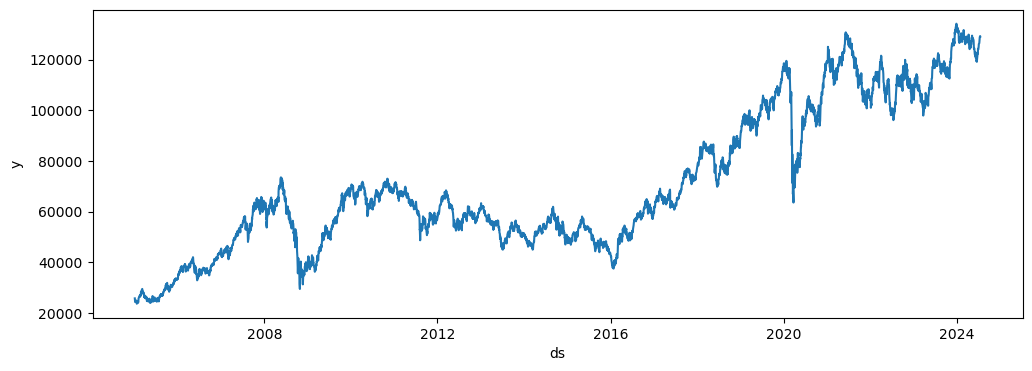

In [13]:
plt.figure(figsize=(12, 4))

sns.lineplot(
    data=df,
    x='ds',
    y='y'
)

## 3. Preparação dos dados

In [14]:
def split_train_test(df, start_date):
    start_date = pd.to_datetime(start_date)
    
    # Filter the DataFrame based on the start_date
    df_split = df[df['ds'] >= start_date]
    
    # Calculate the split index
    split_index = len(df_split) - 183 # 183 dias ~ 6 meses
    
    # Split the DataFrame into train and test
    train = df_split.iloc[:split_index]
    test = df_split.iloc[split_index:]
    
    return {'train': train, 'test': test}

In [15]:
dfs = split_train_test(df_2, datetime.date(2005, 1, 1))

Visualizando os dados de treinamento e teste

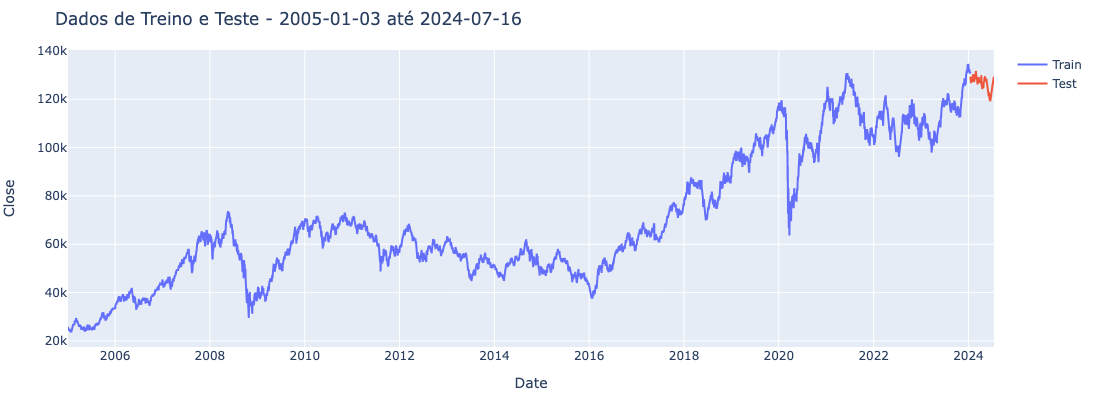

In [18]:
# Criar traços para os dados de treino e teste
train_trace = go.Scatter(x=dfs['train']['ds'], y=dfs['train']['y'], mode='lines', name='Train')
test_trace = go.Scatter(x=dfs['test']['ds'], y=dfs['test']['y'], mode='lines', name='Test')

# Configurar o layout do gráfico
layout = go.Layout(
    title=f'Dados de Treino e Teste - {dfs["train"]["ds"].min().date()} até {dfs["test"]["ds"].max().date()}',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close'),
    margin=dict(l=50, r=50, t=50, b=50),
    width=1000,
    height=400
)

# Criar a figura
fig = go.Figure(data=[train_trace, test_trace], layout=layout)

# Mostrar o gráfico
fig.show()

## 4. Modelo

Vamos utilizar o modelo **SARIMA** para previsão e comparar com a performance do modelo de baseline (Naive):

A métrica de avaliação será o erro médio percentual absoluto (MAPE) e a técnica de validação por Janela Deslizantes.

In [19]:
metrics = pd.DataFrame(columns=['Modelo', 'MAE', 'RMSE', 'MAPE']).set_index('Modelo')

In [20]:
def get_sliding_window_index(df_train, window_train=90, h=3, plot=False):
    """
    Gera índices de janelas deslizantes para treinamento e validação a partir de um DataFrame de treinamento.

    Parâmetros:
    df_train (DataFrame): O DataFrame contendo os dados de treinamento.
    window_train (int): O tamanho da janela de treinamento (default é 90).
    h (int): O horizonte de previsão (número de passos a frente para validação) (default é 3).
    plot (bool): Se True, plota as janelas de treinamento e validação.

    Retorna:
    list_index (list): Uma lista de tuplas contendo os índices (start, end) para as janelas de treinamento e validação.
    """

    # Número de linhas no DataFrame de treinamento
    df_shape = df_train.shape[0]
    # Contador para o número de deslizamentos da janela
    slide = 0

    # Índices iniciais para a primeira janela de treinamento
    train_start = h * slide
    train_end = train_start + window_train

    # Índices iniciais para a primeira janela de validação
    valid_start = train_end
    valid_end = valid_start + h

    # Se plot=True, configurar a figura para visualização das janelas
    if plot:
        plt.figure(figsize=(50, 20))

    # Lista para armazenar as tuplas de índices das janelas de treinamento e validação
    list_index = []

    # Loop para iterar até que a janela de validação exceda o tamanho do DataFrame
    while valid_end < df_shape:

        # Se plot=True, plota as barras das janelas de treinamento e validação
        if plot:
            plt.barh(f'G{slide}', train_end - train_start, left=train_start, color='blue')
            plt.barh(f'G{slide}', valid_end - valid_start, left=valid_start, color='red')

        # Adiciona os índices atuais de treinamento e validação à lista
        list_index.append((train_start, train_end, valid_start, valid_end))

        # Incrementa o contador de deslizamento para a próxima janela
        slide += 1

        # Atualiza os índices para a próxima janela de treinamento
        train_start = h * slide
        train_end = train_start + window_train

        # Atualiza os índices para a próxima janela de validação
        valid_start = train_end
        valid_end = valid_start + h

    # Se plot=True, ajusta os limites do eixo x e aplica layout compacto
    if plot:
        plt.xlim(0, df_train.shape[0])  # Define o limite máximo do eixo x para o tamanho do DataFrame
        plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

    # Retorna a lista de tuplas contendo os índices das janelas
    return list_index



In [45]:
def print_result(df_result, model='-'):
    """
    Plota os resultados de uma predição e calcula métricas de erro.

    Parâmetros:
    df_result (DataFrame): DataFrame contendo as colunas 'ds' (datas), 'y' (valores reais),
                           'y_pred' (valores preditos) e 'diff' (erro de predição).
    model (str): Nome do modelo para identificação nas métricas (default é '-').

    Retorna:
    metrics (DataFrame): DataFrame contendo as métricas de erro MAE, RMSE e MAPE.
    """

    # Cria uma figura com dois subplots lado a lado
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Predição', 'Erro'))

    # Plot do valor real vs predito
    fig.add_trace(
        go.Scatter(x=df_result['ds'], y=df_result['y'], mode='lines', name='Real'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_result['ds'], y=df_result['y_pred'], mode='lines', name='Predito'),
        row=1, col=1
    )

    # Plot do erro de predição (diferença entre valor real e predito)
    fig.add_trace(
        go.Scatter(x=df_result['ds'], y=df_result['diff'], mode='lines', name='Erro'),
        row=1, col=2
    )

    # Ajusta o layout dos gráficos para evitar sobreposição de elementos
    fig.update_layout(
        width=1000,
        height=400,
        title_text=f'Resultados do Modelo: {model}',
        showlegend=True
    )
    
    # Mostra o gráfico
    fig.show()

    # Calcula as métricas de erro: MAE, RMSE e MAPE
    metrics = pd.DataFrame({
        'Modelo': [model],
        'MAE': [df_result['diff'].abs().mean()],  # Erro absoluto médio
        'RMSE': [np.sqrt((df_result['diff']**2).mean())],  # Raiz do erro quadrático médio
        'MAPE': [np.abs(df_result['diff'] / df_result['y']).mean()]  # Erro percentual absoluto médio
    }).set_index('Modelo')

    # Retorna o DataFrame com as métricas de erro
    return metrics

### 4.1 Baseline (Naive)

In [22]:
def cross_val_baseline(df_train, h=3, window_train=90, params={'window_size': 7}):
    """
    Executa a validação cruzada usando um modelo de baseline (média móvel) em uma série temporal.

    Parâmetros:
    df_train (DataFrame): DataFrame contendo as colunas 'ds' (datas) e 'y' (valores reais).
    h (int): Horizonte de previsão (número de passos a frente) (default é 3).
    window_train (int): Tamanho da janela de treinamento (default é 90).
    params (dict): Dicionário contendo o parâmetro 'window_size' para a média móvel (default é {'window_size': 7}).

    Retorna:
    result (DataFrame): DataFrame contendo as datas ('ds'), valores reais ('y'), valores preditos ('y_pred') e erro ('diff').
    """

    print(f'Iniciando validação cruzada da Baseline - df {df_train["ds"].min().year}')
    
    # Cria uma cópia do DataFrame de treinamento e adiciona uma coluna de identificação única
    df_train_baseline = df_train.copy()
    df_train_baseline['unique_id'] = 1

    # Inicializa o modelo de baseline usando média móvel com o tamanho de janela especificado
    model_baseline = StatsForecast(
        models=[WindowAverage(window_size=params['window_size'])],
        freq='D',
        n_jobs=-1
    )

    # Obtém os índices das janelas de treinamento e validação usando a função get_sliding_window_index
    indexes = get_sliding_window_index(df_train_baseline, window_train=window_train, h=h, plot=False)
    
    # DataFrame para armazenar as previsões
    df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

    # Itera sobre cada par de índices de janela para realizar o treinamento e predição
    for index in tqdm(indexes):
        # Extrai a janela de treinamento atual
        df_train = df_train_baseline[index[0]:index[1]]

        # Treina o modelo na janela de treinamento
        model_baseline.fit(df_train)
        
        # Faz a predição para o horizonte h
        predict = model_baseline.predict(h=h)

        # Renomeia a coluna de previsão para 'y_pred'
        predict.rename(columns={'WindowAverage': 'y_pred'}, inplace=True)
        
        # Adiciona as previsões ao DataFrame df_pred
        if df_pred.shape[0] == 0:
            df_pred = predict.reset_index()[['ds', 'y_pred']]
        else:
            df_pred = pd.concat([df_pred, predict.reset_index()[['ds', 'y_pred']]], axis=0)

    # Faz o merge das previsões com o DataFrame de treinamento para obter os valores reais
    result = df_pred.merge(df_train_baseline, on=['ds'], how='right')
    
    # Calcula o erro de predição
    result['diff'] = result['y'] - result['y_pred']

    # Retorna o DataFrame contendo as datas, valores reais, valores preditos e o erro
    return result

Iniciando validação cruzada da Baseline - df 2005


100%|██████████████████████████████████████| 2287/2287 [00:11<00:00, 196.51it/s]


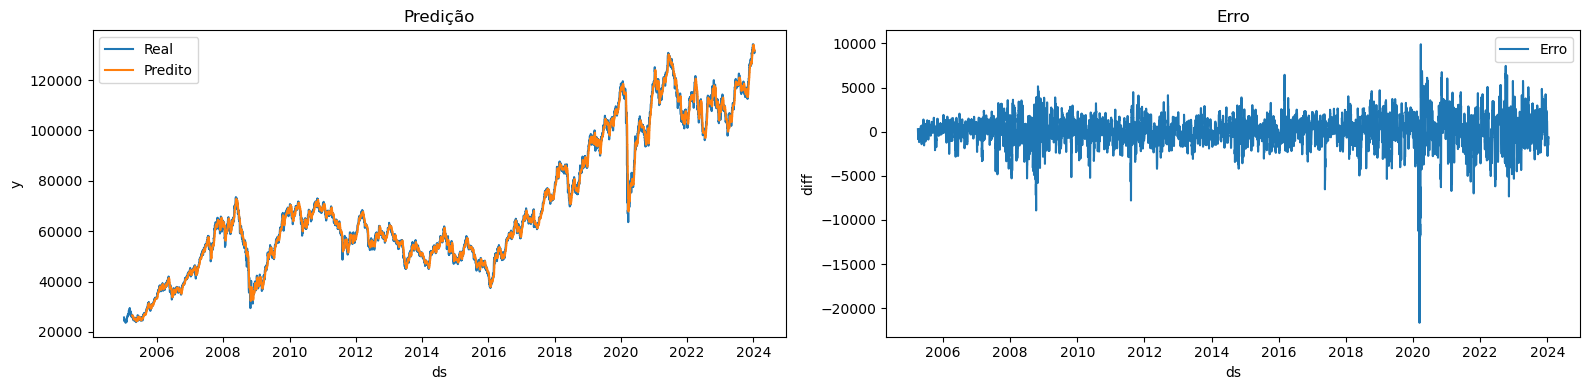

,MAE,RMSE,MAPE
Modelo,,,
Baseline - 2005,1252.357614,1736.434641,0.018968


In [23]:
# Executa a validação cruzada usando o modelo baseline
result = cross_val_baseline(dfs["train"], h=3, window_train=90, params={'window_size': 7})

# Plota os resultados e calcula as métricas para o modelo baseline
result_metrics = print_result(result, model=f'Baseline - {dfs["train"]["ds"].min().year}')

# Concatena as métricas do modelo baseline com outras métricas existentes
metrics = pd.concat([metrics, result_metrics], axis=0)

# Exibe o DataFrame contendo as métricas
metrics

### 4.2 SARIMA

In [24]:
def cross_val_sarima(df_train, h=3, window_train=90, params={'seasonal': False}):
    """
    Executa a validação cruzada usando um modelo ARIMA/SARIMA em uma série temporal.

    Parâmetros:
    df_train (DataFrame): DataFrame contendo as colunas 'ds' (datas) e 'y' (valores reais).
    h (int): Horizonte de previsão (número de passos a frente) (default é 3).
    window_train (int): Tamanho da janela de treinamento (default é 90).
    params (dict): Dicionário contendo o parâmetro 'seasonal' (indica se o modelo é sazonal) (default é {'seasonal': False}).

    Retorna:
    result (DataFrame): DataFrame contendo as datas ('ds'), valores reais ('y'), valores preditos ('y_pred') e erro ('diff').
    """

    # Mensagem de início da validação cruzada
    print(f'Iniciando validação cruzada do ARIMA/SARIMA - df {df_train["ds"].min().year}')

    # Cópia do DataFrame de treinamento para evitar modificações no original
    df_train_arima = df_train.copy()

    # Obter índices de janelas deslizantes
    indexes = get_sliding_window_index(df_train_arima, window_train=window_train, h=h, plot=False)

    # DataFrame para armazenar previsões
    df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

    # Loop sobre cada janela deslizante
    for index in tqdm(indexes):
        # Extrair a janela de treinamento atual
        df_train = df_train_arima[index[0]:index[1]]

        # Ajustar o modelo ARIMA/SARIMA
        model_arima = auto_arima(
            df_train['y'],
            seasonal=params['seasonal'],
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
        )
        
        # Fazer previsões para o horizonte de previsão h
        predict = model_arima.predict(n_periods=h)
        
        # Criar DataFrame temporário para armazenar previsões
        predict_temp = pd.DataFrame(predict, columns=['y_pred'])
        predict_temp['ds'] = df_train_arima[index[2]:index[3]]['ds']

        # Concatenar previsões no DataFrame df_pred
        if df_pred.shape[0] == 0:
            df_pred = predict_temp[['ds', 'y_pred']]
        else:
            df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

    # Unir previsões com os dados reais
    result = df_pred.merge(df_train_arima, on=['ds'], how='right')
    result['diff'] = result['y'] - result['y_pred']

    # Retornar DataFrame com previsões e diferenças
    return result

In [27]:
def grid_search_sarima(df_train, params={'window_train': [15, 30, 60, 90, 120], 'seasonal': [False, True]}):
    """
    Executa uma busca em grade (grid search) para encontrar os melhores parâmetros para o modelo ARIMA/SARIMA.

    Parâmetros:
    df_train (DataFrame): DataFrame contendo as colunas 'ds' (datas) e 'y' (valores reais).
    params (dict): Dicionário contendo as listas de parâmetros para 'window_train' (tamanho da janela de treinamento) e
                   'seasonal' (indica se o modelo é sazonal).

    Retorna:
    infos (list): Lista de dicionários com os resultados das métricas para cada combinação de parâmetros testada.
    """

    # Cópia do DataFrame de treinamento para evitar modificar o original
    df = df_train.copy()

    # DataFrame para armazenar métricas
    metrics = pd.DataFrame(columns=['N Search', 'MAE', 'RMSE', 'MAPE']).set_index('N Search')
    # Lista para armazenar informações das buscas
    infos = []
    # Contador de buscas
    n_search = 0
    
    # Loop para cada combinação de parâmetros na busca em grade
    for window_train in params['window_train']:
        for seasonal in params['seasonal']:

            print(f'\nwindow_train: {window_train}, seasonal: {seasonal}')

            # Obter índices de janelas deslizantes
            indexes = get_sliding_window_index(df, window_train=window_train, h=3, plot=False)
            # Listas para armazenar métricas de cada janela
            cross_mae = []
            cross_rmse = []
            cross_mape = []

            # DataFrame para armazenar previsões
            df_pred = pd.DataFrame(columns=['ds', 'y_pred'])
            
            # Loop sobre cada janela deslizante
            for index in tqdm(indexes):
                df_train = df[index[0]:index[1]].copy()
                df_test = df[index[2]:index[3]].copy()

                # Ajustar o modelo ARIMA/SARIMA
                model_arima = auto_arima(
                    df_train['y'],
                    seasonal=seasonal,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                )
                
                # Fazer previsões para o horizonte de previsão (h=3)
                predict = model_arima.predict(n_periods=3)
                
                # Criar DataFrame temporário para previsões
                predict_temp = pd.DataFrame(predict, columns=['y_pred'])
                predict_temp['ds'] = df_test['ds']

                # Concatenar previsões no DataFrame df_pred
                if df_pred.shape[0] == 0:
                    df_pred = predict_temp[['ds', 'y_pred']]
                else:
                    df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

                # Unir previsões com dados reais
                result = df_pred.merge(df, on=['ds'], how='right')
                result['diff'] = result['y'] - result['y_pred']

                # Calcular métricas
                mae = result['diff'].abs().mean()
                rmse = np.sqrt((result['diff']**2).mean())
                mape = np.abs(result['diff'] / result['y']).mean()

                # Adicionar métricas às listas de validação cruzada
                cross_mae.append(mae)
                cross_rmse.append(rmse)
                cross_mape.append(mape)

            # Salvar resultados da iteração do grid search
            infos.append({
                'window_train': window_train,
                'seasonal': seasonal,
                'MAE': np.mean(cross_mae),
                'RMSE': np.mean(cross_rmse),
                'MAPE': np.mean(cross_mape)
            })

            print(f"MAE: {np.mean(cross_mae)} / RMSE: {np.mean(cross_rmse)} / MAPE: {np.mean(cross_mape)}")
            
            # Incrementar o número de buscas
            n_search += 1
                
    return infos

In [28]:
grid_search_sarima(dfs['train'], params = {'window_train': [15, 45, 90, 180, 365], 'seasonal': [True]})


window_train: 15, seasonal: True


100%|███████████████████████████████████████| 2312/2312 [14:31<00:00,  2.65it/s]


MAE: 805.795941562681 / RMSE: 1173.8376922228497 / MAPE: 0.01658195708401452

window_train: 45, seasonal: True


100%|███████████████████████████████████████| 2302/2302 [15:25<00:00,  2.49it/s]


MAE: 704.4437211405253 / RMSE: 1083.1319184829179 / MAPE: 0.01434930244446356

window_train: 90, seasonal: True


100%|███████████████████████████████████████| 2287/2287 [17:22<00:00,  2.19it/s]


MAE: 707.7783807339321 / RMSE: 1097.5095519569325 / MAPE: 0.014286170178135498

window_train: 180, seasonal: True


100%|███████████████████████████████████████| 2257/2257 [21:05<00:00,  1.78it/s]


MAE: 694.9713368651824 / RMSE: 1088.6458167770675 / MAPE: 0.0136786459019625

window_train: 365, seasonal: True


100%|███████████████████████████████████████| 2195/2195 [29:06<00:00,  1.26it/s]

MAE: 734.8713759760122 / RMSE: 1119.3200102370233 / MAPE: 0.013958849398517244


[{'N Search': 0,
  'window_train': 15,
  'seasonal': True,
  'MAE': 805.795941562681,
  'RMSE': 1173.8376922228497,
  'MAPE': 0.01658195708401452},
 {'N Search': 1,
  'window_train': 45,
  'seasonal': True,
  'MAE': 704.4437211405253,
  'RMSE': 1083.1319184829179,
  'MAPE': 0.01434930244446356},
 {'N Search': 2,
  'window_train': 90,
  'seasonal': True,
  'MAE': 707.7783807339321,
  'RMSE': 1097.5095519569325,
  'MAPE': 0.014286170178135498},
 {'N Search': 3,
  'window_train': 180,
  'seasonal': True,
  'MAE': 694.9713368651824,
  'RMSE': 1088.6458167770675,
  'MAPE': 0.0136786459019625},
 {'N Search': 4,
  'window_train': 365,
  'seasonal': True,
  'MAE': 734.8713759760122,
  'RMSE': 1119.3200102370233,
  'MAPE': 0.013958849398517244}]

Iniciando validação cruzada do ARIMA/SARIMA - df 2005


100%|███████████████████████████████████████| 2257/2257 [39:31<00:00,  1.05s/it]


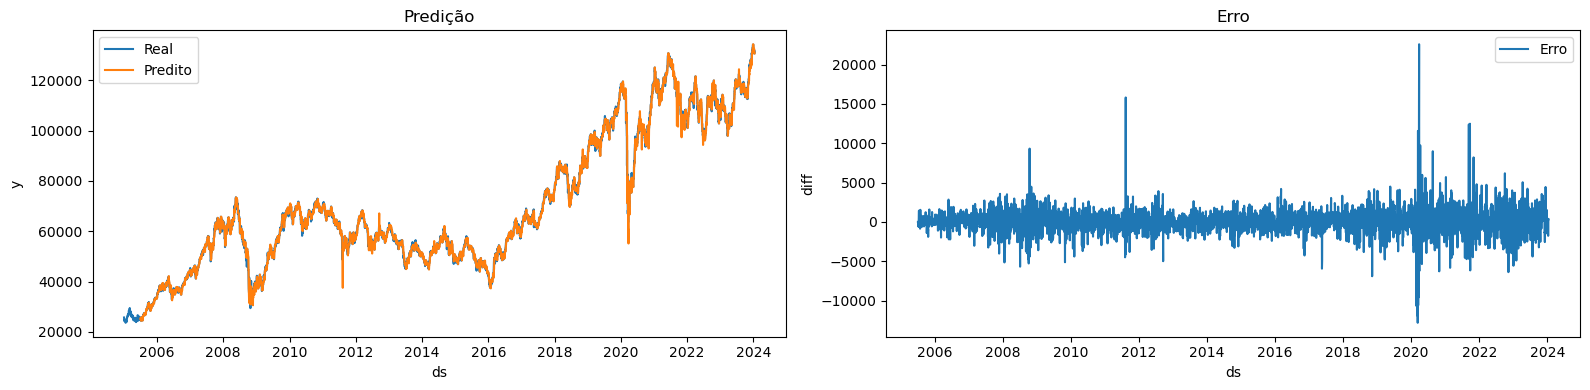

,MAE,RMSE,MAPE
Modelo,,,
Baseline - 2005,1252.357614,1736.434641,0.018968
ARIMA - 2005,866.642457,1416.829964,0.012902


In [29]:
result = cross_val_sarima(dfs['train'], h = 3, window_train = 180)
result_metrics = print_result(result, model = f'ARIMA - { dfs["train"]["ds"].min().year }')

metrics = pd.concat([metrics, result_metrics], axis=0)
metrics

## 5. Avaliando os Modelos

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 59.58it/s]


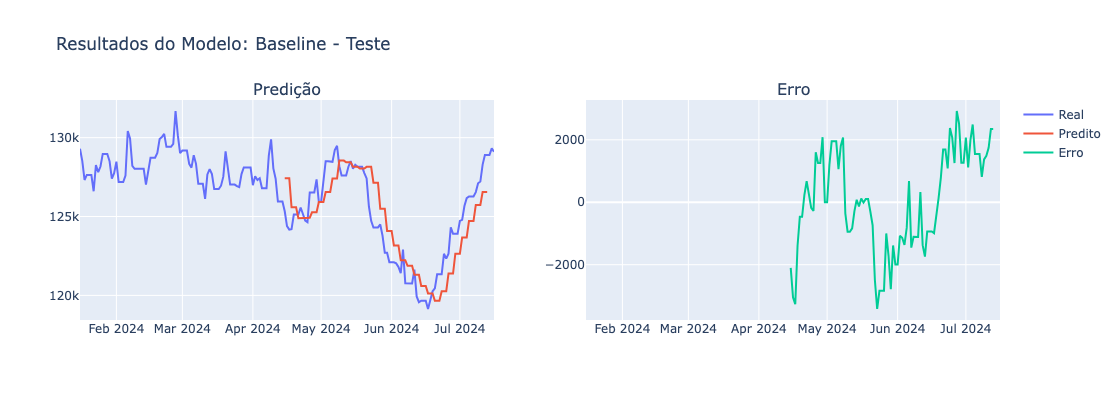

,MAE,RMSE,MAPE
Modelo,,,
Baseline - Teste,1331.424479,1580.752611,0.010687


In [34]:
# Copiar o DataFrame de teste para evitar modificar o original
df_test_baseline = dfs['test'].copy()
df_test_baseline['unique_id'] = 1

# Instanciar o modelo de previsão com média móvel
model_baseline = StatsForecast(
    models=[WindowAverage(window_size=7)],  # Janela de média móvel de 7 dias
    freq='D',  # Frequência diária dos dados
    n_jobs=-1  # Usar todos os núcleos disponíveis para o processamento paralelo
)

# Obter os índices das janelas deslizantes para o conjunto de teste
indexes = get_sliding_window_index(df_test_baseline, window_train=90, h=3, plot=False)
# DataFrame para armazenar as previsões
df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

# Loop sobre cada janela deslizante
for index in tqdm(indexes):
    # Obter a janela de dados de teste
    df_test = df_test_baseline[index[0]:index[1]]

    # Treinar o modelo com os dados da janela de teste
    model_baseline.fit(df_test)
    # Fazer previsões para o horizonte de previsão h=3
    predict = model_baseline.predict(h=3)

    # Renomear a coluna de previsões
    predict.rename(columns={'WindowAverage': 'y_pred'}, inplace=True)
    # Concatenar as previsões ao DataFrame df_pred
    if df_pred.shape[0] == 0:
        df_pred = predict.reset_index()[['ds', 'y_pred']]
    else:
        df_pred = pd.concat([df_pred, predict.reset_index()[['ds', 'y_pred']]], axis=0)

# Unir as previsões com os dados reais
result = df_pred.merge(df_test_baseline, on=['ds'], how='right')
result['diff'] = result['y'] - result['y_pred']

# Chamar a função para imprimir o resultado e calcular as métricas
print_result(result, model='Baseline - Teste')

100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.17it/s]


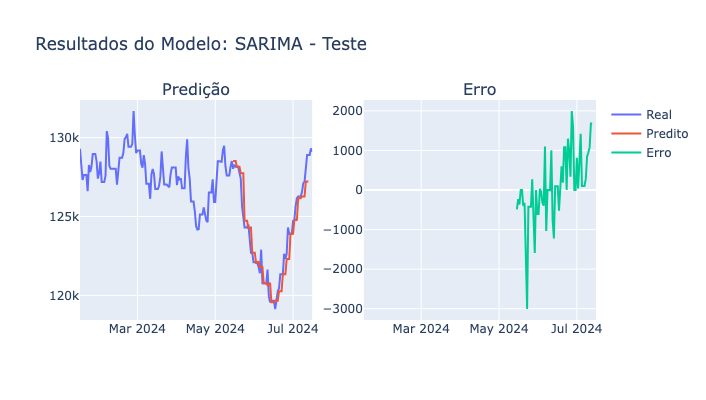

,MAE,RMSE,MAPE
Modelo,,,
SARIMA - Teste,627.121109,895.469837,0.00505


In [46]:
# Copiando os dados de teste para evitar modificações no original
df_test_arima = dfs['test'].copy()

# Obter índices de janelas deslizantes
indexes = get_sliding_window_index(df_test_arima, window_train=120, h=3, plot=False)

# DataFrame para armazenar previsões
df_pred = pd.DataFrame(columns=['ds', 'y_pred'])

# Loop sobre cada janela deslizante
for index in tqdm(indexes):
    # Selecionar os dados de teste usando a janela deslizante
    df_test = df_test_arima[index[0]:index[1]]

    # Ajustar modelo ARIMA com sazonalidade
    model_arima = auto_arima(
        df_test['y'],
        seasonal=True,          # Especifica que o modelo deve considerar sazonalidade
        trace=False,            # Não exibir a saída do processo de ajuste
        error_action='ignore',  # Ignorar erros que ocorrem durante o ajuste
        suppress_warnings=True  # Suprimir avisos durante o ajuste
    )
    
    # Fazer previsões para o horizonte de previsão (3 períodos)
    predict = model_arima.predict(n_periods=3)
    
    # Criar DataFrame temporário para previsões
    predict_temp = pd.DataFrame(predict, columns=['y_pred'])
    predict_temp['ds'] = df_test_arima[index[2]:index[3]]['ds']

    # Concatenar previsões ao DataFrame de previsões final
    if df_pred.shape[0] == 0:
        df_pred = predict_temp[['ds', 'y_pred']]
    else:
        df_pred = pd.concat([df_pred, predict_temp[['ds', 'y_pred']]], axis=0)

# Unir previsões com dados reais
result = df_pred.merge(df_test_arima, on=['ds'], how='right')
result['diff'] = result['y'] - result['y_pred']

# Imprimir resultados
print_result(result, model='SARIMA - Teste')


## 6. Testando

In [57]:
# Preparar os dados
df_deploy = df_original.copy()  # Fazer uma cópia dos dados originais

# Selecionar apenas as colunas de data e preço
df_deploy = df_deploy[['Date', 'Price']]
df_deploy['Date'] = pd.to_datetime(df_deploy['Date'], format='%m/%d/%Y')  # Converter a coluna de data para o formato datetime
df_deploy = df_deploy.rename(columns={'Date': 'ds', 'Price': 'y'})  # Renomear colunas para 'ds' (data) e 'y' (valor)
df_deploy['y'] = df_deploy['y'].str.replace(',', '').astype(int)  # Remover vírgulas e converter valores para inteiros

df_deploy.set_index('ds', inplace=True)  # Definir a coluna de datas como índice

# Preencher valores ausentes (forward fill)
df_deploy = df_deploy.asfreq('D')  # Definir a frequência das datas como diária
df_deploy = df_deploy.ffill()  # Preencher valores ausentes com o valor anterior (forward fill)
df_deploy = df_deploy.sort_index()  # Ordenar pelo índice de datas

# Definir o intervalo de dados para análise (últimos 45 dias)
end_date = df_deploy.index[-1]
start_date = end_date - pd.Timedelta(days=45)

# Selecionar subset dos dados para análise
df_subset = df_deploy.loc[start_date:end_date]

# Ajustar o modelo SARIMA com sazonalidade
model_arima = auto_arima(
    df_subset['y'],  # Usar a coluna de preços de fechamento
    seasonal=True,  # Considerar sazonalidade
    trace=True,  # Mostrar progresso do ajuste
    error_action='ignore',  # Ignorar erros e continuar
    suppress_warnings=True,  # Suprimir avisos
)

# Fazer previsões para os próximos 3 períodos (dias)
n_periods = 10
predict = model_arima.predict(n_periods=n_periods)

# Criar um DataFrame para armazenar previsões
future_dates = pd.date_range(start=df_deploy.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
predictions = pd.DataFrame({'ds': future_dates, 'y_pred': predict})

# Exibir previsões
print(predictions)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=730.652, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=739.538, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=741.312, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=741.311, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=729.130, Time=0.23 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=722.895, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=731.905, Time=0.15 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=724.149, Time=0.19 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=726.285, Time=0.18 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=729.408, Time=0.20 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=723.604, Time=0.14 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=728.528, Time=0.2